# **Example generation of results**

#### **Last update: 11th June, 2025**
<br>

This notebook generates the results based on the output from the simulations of the reproducible example. The code is largely derived from the codes used in the original process_results.ipynb, but consists of two parts instead of three (excluding the part of simulating datasets of different sizes) and is slightly adjusted to match the data.

**Part I: Set-up**
- **1. Import the packages and functions**
- **2. Import the intervention and prognsos review datasets** <br>

**Part II: Simulations with original review datasets** 
- **3. Retrieve and merge the output from all simulations**
- **4. Compute performance metrics from the retrieved simulation output**
- **5. Create raw tables with all performance metrics seperately**
- **6. Process raw tables into pooled tabels (for results)**
- **7. Create histograms for WSS and precision (for results)** 
- **8. Create boxplots/lineplots of increasing recall during screening (for results)** <br>

## Part I: Set-up

### 1. Import the packages and functions

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import pickle
import os
import shutil
import math
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import collections
import warnings

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from functions import compute_metrics
from functions import generate_recall_table_prop, max_recall_prop
from functions import generate_wss_table, generate_results_table

In [3]:
from asreview.models.classifiers import LogisticClassifier, LSTMBaseClassifier, LSTMPoolClassifier, NaiveBayesClassifier, NN2LayerClassifier, RandomForestClassifier, SVMClassifier
from asreview.models.query import ClusterQuery, MaxQuery, MaxRandomQuery, MaxUncertaintyQuery, RandomQuery, UncertaintyQuery
from asreview.models.balance import DoubleBalance, SimpleBalance, UndersampleBalance
from asreview.models.feature_extraction import Doc2Vec, EmbeddingIdf, EmbeddingLSTM, SBERT, Tfidf
from asreview import open_state

from pathlib import Path

In [4]:
os.environ['TRANSFORMERS_CACHE'] = '/tmp/transformers_cache'
os.environ['TORCH_HOME'] = '/tmp/torch_cache'

In [5]:
os.chdir("..")
os.getcwd()

'/Users/ispiero2/TAR-abstracts_testing'

In [6]:
path_data = "data/processed/"
path_results = 'output/tmp/'
path_results_HPC = 'output/rankings/' # though the results are not from the HPC in this example

### 2. Import the intervention and prognosis review datasets

The intervention review datasets that were used for simulation are imported (numbering of the datasets is ordered by authors), and the prognosis review datasets that were used for simulation are imported (numbering of the datasets is ordered by author, so numbers do not correspond to numbers in data prep):

In [7]:
# Load all the review datasets from the dataset-containing folder into a dictionary
review_dic = {}

for file_name in os.listdir(path_data):
    if file_name.endswith('.csv'): 
        file_path = os.path.join(path_data, file_name)
        df = pd.read_csv(file_path)
        key = os.path.splitext(file_name)[0].split("_")[0]
        review_dic[key] = df

review_dic = dict(sorted(review_dic.items()))

## Part II: Simulations with original review datasets

### 3. Retrieve and merge the output from all simulations

To assess the performance of the semi-automated screening tool, not only the reviews, but also the classification models, feature extraction models, and/or query models were varied in the simulations:

In [8]:
# Specify the the classification, feature extraction, and query model(s) that were tested
train_models = [LogisticClassifier(), NaiveBayesClassifier()] 
feature_models =  [Tfidf()]
query_models = [MaxQuery()]

# Specify the number of simulations per review-model combination  
n_simulations = 10 #

All the output from the simulations of these variations (conducted on the HPC) can then be retrieved and merged as follows:

In [9]:
# Create a list of the review-model combination names
sim_list_names = []
for review in review_dic:
    for train_model in train_models:
        for feature_model in feature_models:
            for query_model in query_models:
                review_id = str(review + "_" + train_model.name + "_" + feature_model.name + "_" + query_model.name)
                sim_list_names.append(review_id)
            
# Retrieve the output from the HPC generated pickle files with each having the rankings of a single simulation
multiple_sims = []
for i in range(0, len(sim_list_names)):
    raw_output = {}
    for j in range(1,n_simulations+1):
        if Path(path_results_HPC +'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j)).is_file():
            with open(path_results_HPC + 'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j),'rb') as f:
                raw_output.update(pickle.load(f))
    if len(raw_output) > 0:
        multiple_sims.append((sim_list_names[i], len(review_dic[sim_list_names[i].split('_')[0]]), n_simulations, raw_output))

In [10]:
# Save (back-up) the file with the simulation results 
with open(path_results + 'multiple_sims.p','wb') as f:
     pickle.dump(multiple_sims, f)

or the output can be directly opened from the already saved file:

In [11]:
# Open the file with the simulation results
with open(path_results + 'multiple_sims.p','rb') as f:
    multiple_sims = pickle.load(f)

### 4. Compute performance metrics from the retrieved simulation output

The proportions (i.e. proportion of records screened) and sample sizes (i.e. the number of records screened) of interest can be defined. These are then used for evaluation of the ranking of the records and to calculate the performance metrics at each of these proportions/sample sizes screened. These calculations may take a while to run, therefore they were previously saved and can also directly be opened.

In [12]:
proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sample_sizes = list(map(int,list(np.linspace(0, 99, 100,retstep = True)[0]))) + list(map(int,list(np.linspace(100, 12400, 124,retstep = True)[0])))

Using these proportions and sizes, the following function can be used to derive the performance metrics of the simulation(s):

In [13]:
# Use the compute_metrics function to compute the metrics from the retrieved simulation output
warnings.filterwarnings('ignore')
raw_output = compute_metrics.compute_metrics(multiple_sims, proportions, sample_sizes)

CD005139_logistic_tfidf_max
CD005139_nb_tfidf_max
CD006468_logistic_tfidf_max
CD006468_nb_tfidf_max
CD008170_logistic_tfidf_max
CD008170_nb_tfidf_max
CD008201_logistic_tfidf_max
CD008201_nb_tfidf_max
CD010038_logistic_tfidf_max
CD010038_nb_tfidf_max
CD010558_logistic_tfidf_max
CD010558_nb_tfidf_max
CD011768_logistic_tfidf_max
CD011768_nb_tfidf_max


In [14]:
# Save (back-up) a file with the computed output
with open(path_results + 'sims_output.p','wb') as f:
    pickle.dump(raw_output, f)

Or directly open the file containing the output (as these especially take a while to run):

In [15]:
# Open the file with the computed output
with open(path_results + 'sims_output.p','rb') as f:
    raw_output = pickle.load(f)

### 5. Create raw tables with all performance metrics seperately

Filter the (for now) relevant parts of the output for the results:

In [16]:
evaluation = {}
for i in range(0, len(raw_output)):
    evaluation[raw_output[i][0]] = []
    evaluation[raw_output[i][0]].append(raw_output[i][3:9])
    
import warnings
warnings.filterwarnings('ignore')

Create a raw table with the performance metrics for proportions:

In [17]:
# Use the generate_recall_table_prop function to generate a table with all recall values for all proportions
df_prop = generate_recall_table_prop.generate_recall_table_prop(evaluation, proportions, n_simulations)
df_prop.head()

,Review,Simulation number,Train model,Feature model,Query model,Simulation,percentage of records screened,recall,Review_full,Models
0,CD005139,1,logistic,tfidf,max,CD005139 (logistic - tfidf),0%,0.000000,CD005139,tfidf - logistic
1,CD005139,1,logistic,tfidf,max,CD005139 (logistic - tfidf),10%,0.693069,CD005139,tfidf - logistic
2,CD005139,1,logistic,tfidf,max,CD005139 (logistic - tfidf),20%,0.940594,CD005139,tfidf - logistic
3,CD005139,1,logistic,tfidf,max,CD005139 (logistic - tfidf),30%,0.970297,CD005139,tfidf - logistic
4,CD005139,1,logistic,tfidf,max,CD005139 (logistic - tfidf),40%,0.990099,CD005139,tfidf - logistic


Calculate the maximum recall values that could be obtained at each of the proportions screened:

In [18]:
# Sort the dictionary
review_dic_ord = collections.OrderedDict(sorted(review_dic.items()))
# Use the max_recall_prop function to calculate the maximum achievable recall for each review
df_max_recalls = max_recall_prop.max_recall_prop(review_dic_ord, proportions)
df_max_recalls.head()

,Review,Maximum recall
0,CD005139,0.0
1,CD005139,1.0
2,CD005139,1.0
3,CD005139,1.0
4,CD005139,1.0


Create a raw table with the work-saved-over sampling, normalized work-saved-over sampling, workload reduction in number of records, and workload reduction in hours:

In [19]:
# Use the generate_wss_table function to create a table with the workload metrics
df_wss = generate_wss_table.generate_wss_table(evaluation, n_simulations)

df_wss.head()

,Review,Train model,Feature model,Query model,Simulation,WSS@95%,n-WSS@95%,Workload reduction (n),Workload reduction (hours)
0,CD005139,logistic,tfidf,max,1,0.747014,0.813021,4217,35.1
1,CD005139,logistic,tfidf,max,2,0.720932,0.786380,4079,34.0
2,CD005139,logistic,tfidf,max,3,0.739076,0.804913,4175,34.8
3,CD005139,logistic,tfidf,max,4,0.688991,0.753755,3910,32.6
4,CD005139,logistic,tfidf,max,5,0.747014,0.813021,4217,35.1


Create a raw table with the precision metric:

In [20]:
df_prec = pd.DataFrame()
length = n_simulations
for key, value in evaluation.items():
    names = key.split('_')
    review = [names[0]] * length
    train_model = [names[1]] * length
    feature_model = [names[2]] * length
    query_model = [names[3]] * length
    simulations = range(1, n_simulations+1)
    precision = value[0][4]['Precision'] ###
    df_sim = pd.DataFrame(list(zip(review,train_model,feature_model,query_model,simulations, precision)),
                           columns = ['Review', 'Train model', 'Feature model', 'Query model', 'Simulation', 'Precision@95%'])
    df_prec = pd.concat([df_prec, df_sim])

    df_prec = df_prec.reset_index(drop = True)
    
df_prec.head()

,Review,Train model,Feature model,Query model,Simulation,Precision@95%
0,CD005139,logistic,tfidf,max,1,0.087523
1,CD005139,logistic,tfidf,max,2,0.079208
2,CD005139,logistic,tfidf,max,3,0.085125
3,CD005139,logistic,tfidf,max,4,0.069515
4,CD005139,logistic,tfidf,max,5,0.087523


### 6. Process raw tables into pooled tables (for results)

The generate_results_table function creates the table containing the WSS and precision values as presented in te results (df_wss_prec) and the table used for create figures (df_wss_prec_all_values):

In [21]:
df_wss_prec_all_values, df_wss_prec = generate_results_table.generate_results_table(df_wss, df_prec)

df_wss_prec_all_values.head()

,Review,Train model,Feature model,Mean_WSS95,ci95_hi_WSS95,ci95_lo_WSS95,Mean_nWSS95,ci95_hi_nWSS95,ci95_lo_nWSS95,Mean_prec95,ci95_hi_prec95,ci95_lo_prec95,Mean_workred_n,ci95_hi_workred_n,ci95_lo_workred_n,Mean_workred_hr,ci95_hi_workred_hr,ci95_lo_workred_hr,Models
0,CD005139,logistic,tfidf,0.730,0.742,0.719,0.796,0.808,0.784,0.082,0.086,0.079,"4,129",4191,4066,34.4,34.9,33.9,tfidf - logistic
1,CD005139,nb,tfidf,0.675,0.686,0.664,0.739,0.750,0.728,0.065,0.068,0.063,"3,834",3893,3776,31.9,32.4,31.5,tfidf - nb
2,CD006468,logistic,tfidf,0.786,0.797,0.774,0.846,0.858,0.835,0.060,0.062,0.059,"3,237",3281,3194,27.0,27.3,26.6,tfidf - logistic
3,CD006468,nb,tfidf,0.790,0.802,0.778,0.851,0.862,0.839,0.065,0.068,0.061,"3,254",3299,3209,27.1,27.5,26.7,tfidf - nb
4,CD008170,logistic,tfidf,0.618,0.622,0.614,0.672,0.676,0.668,0.018,0.019,0.018,"8,225",8274,8177,68.6,69.0,68.2,tfidf - logistic


In [22]:
df_wss_prec.head()

,Review,Train model,Feature model,WSS@95%recall (CI),n-WSS@95%recall (CI),Precision@95%recall (CI),Workload reduction in record numbers (CI),Workload reduction in hours (CI)
0,CD005139,logistic,tfidf,0.730 (0.719-0.742),0.796 (0.784-0.808),0.082 (0.079-0.086),"4,129 (4066-4191)",34.4 (33.9-34.9)
1,CD005139,nb,tfidf,0.675 (0.664-0.686),0.739 (0.728-0.750),0.065 (0.063-0.068),"3,834 (3776-3893)",31.9 (31.5-32.4)
2,CD006468,logistic,tfidf,0.786 (0.774-0.797),0.846 (0.835-0.858),0.060 (0.059-0.062),"3,237 (3194-3281)",27.0 (26.6-27.3)
3,CD006468,nb,tfidf,0.790 (0.778-0.802),0.851 (0.839-0.862),0.065 (0.061-0.068),"3,254 (3209-3299)",27.1 (26.7-27.5)
4,CD008170,logistic,tfidf,0.618 (0.614-0.622),0.672 (0.668-0.676),0.018 (0.018-0.019),"8,225 (8177-8274)",68.6 (68.2-69.0)


### 7. Create histograms for WSS and precision (for results)

Create histograms for (n-)WSS and precision for intervention and prognosis reviews seperately:

In [23]:
def generate_histograms(dataset, x, variables, y_labels, review_types, y_lims, hue = 'Models'):
    
    model_order_full = [
        'tfidf - nb',
        'tfidf - svm',
        'tfidf - logistic',
        'sbert - svm',
        'sbert - logistic'
    ]
    
    # Determine which models are actually present
    present_models = [model for model in model_order_full if model in dataset['Models'].unique()]
    
    # Set the order conditionally
    dataset['Models'] = dataset['Models'].astype(pd.CategoricalDtype(categories=present_models, ordered=True))

    # Change dtype to numeric
    for variable in variables:
        dataset[variable] = pd.to_numeric(dataset[variable])
        
    # Create a histogram for each variable and review type
    for i in range(0, len(variables)):
        for j in review_types:
           
            sns.barplot(x=x, y=variables[i], hue=hue, 
                        data=dataset[dataset['Review'].str.startswith(j)]).set(ylabel=y_labels[i],ylim=(0,y_lims[i]))
            plt.xticks(rotation=45)
            plt.legend(fontsize='10', title_fontsize='14', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()

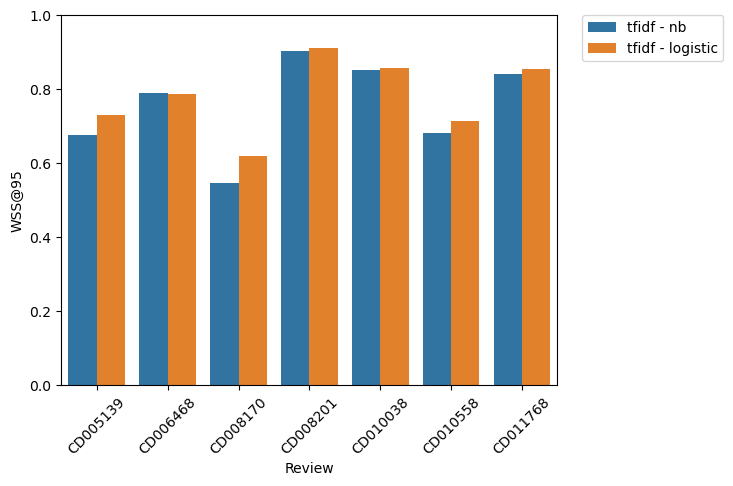

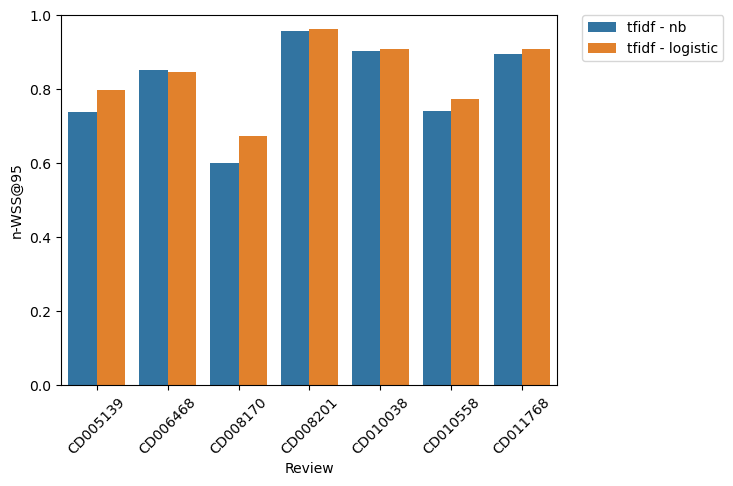

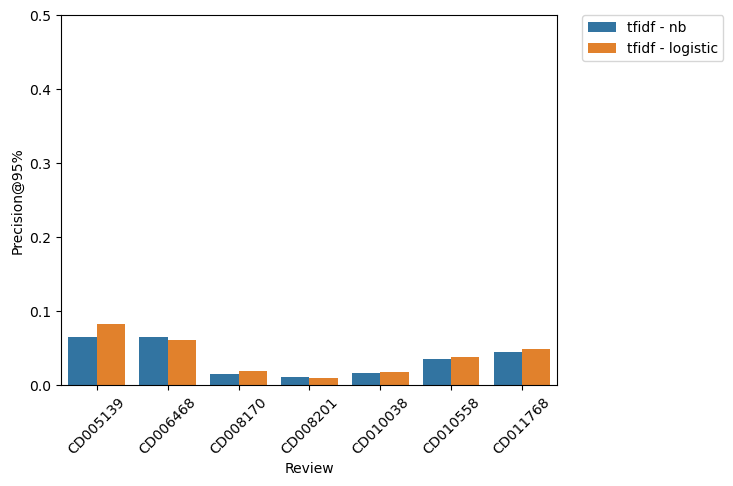

In [24]:
# Choose variables to plot
variables_to_plot = ['Mean_WSS95', 'Mean_nWSS95', 'Mean_prec95']
variable_names = ['WSS@95', 'n-WSS@95', 'Precision@95%']
y_lims = [1,1,0.5]

review_types = ['C']
generate_histograms(dataset=df_wss_prec_all_values, 
                    x='Review',
                    variables=variables_to_plot, 
                    y_labels=variable_names, 
                    review_types=review_types,
                    y_lims=y_lims)

### 8. Create boxplots/lineplots of increasing recall during screening (for results)

Create boxplots for the simulations of the default models (or any other subset of data/modeling methods):

In [25]:
def generate_boxplots(df_prop, df_max_recalls, subset_models = None, subset_reviews = None):
    
    # Select the subset from the dataframe containing all recall values for each proportion screened
    df_boxplots = df_prop.copy()
    
    if subset_models != None:
        models = '|'.join(subset_models)
        df_boxplots = df_boxplots[df_boxplots['Simulation'].str.contains(models, regex=True)]
    if subset_reviews != None:
        reviews = '|'.join(subset_reviews)
        df_boxplots = df_boxplots[df_boxplots['Review'].str.contains(reviews, regex=True)]
 
    # Create a figure with boxplots for each review-model combination seperately
    sns.set(style = 'ticks', font_scale = 1.5)
    p1 = sns.catplot(data = df_boxplots, x = 'percentage of records screened', y = 'recall',
                     col = 'Simulation', kind = 'box', col_wrap = 2, color = 'white', aspect = 1.3)
 
    axes = p1.fig.axes
    x_axis = df_boxplots['percentage of records screened'][0:11]
 
    for i in range(0, len(df_boxplots['Simulation'].unique())):
        review = df_boxplots.loc[df_boxplots['Simulation'] == df_boxplots['Simulation'].unique()[i], 'Review'].values[0]
        max_recalls_per_prop = df_max_recalls.loc[df_max_recalls['Review'] == review]['Maximum recall']    
        axes[i].plot(x_axis, max_recalls_per_prop+0.005, 'k-', linewidth = 1, color = 'black', linestyle = '--', label = "maximal recall")   
        axes[i].legend(loc="lower right")
    p1.set_titles(col_template = "{col_name}", size = 16, weight = 'bold')
 
    plt.show()

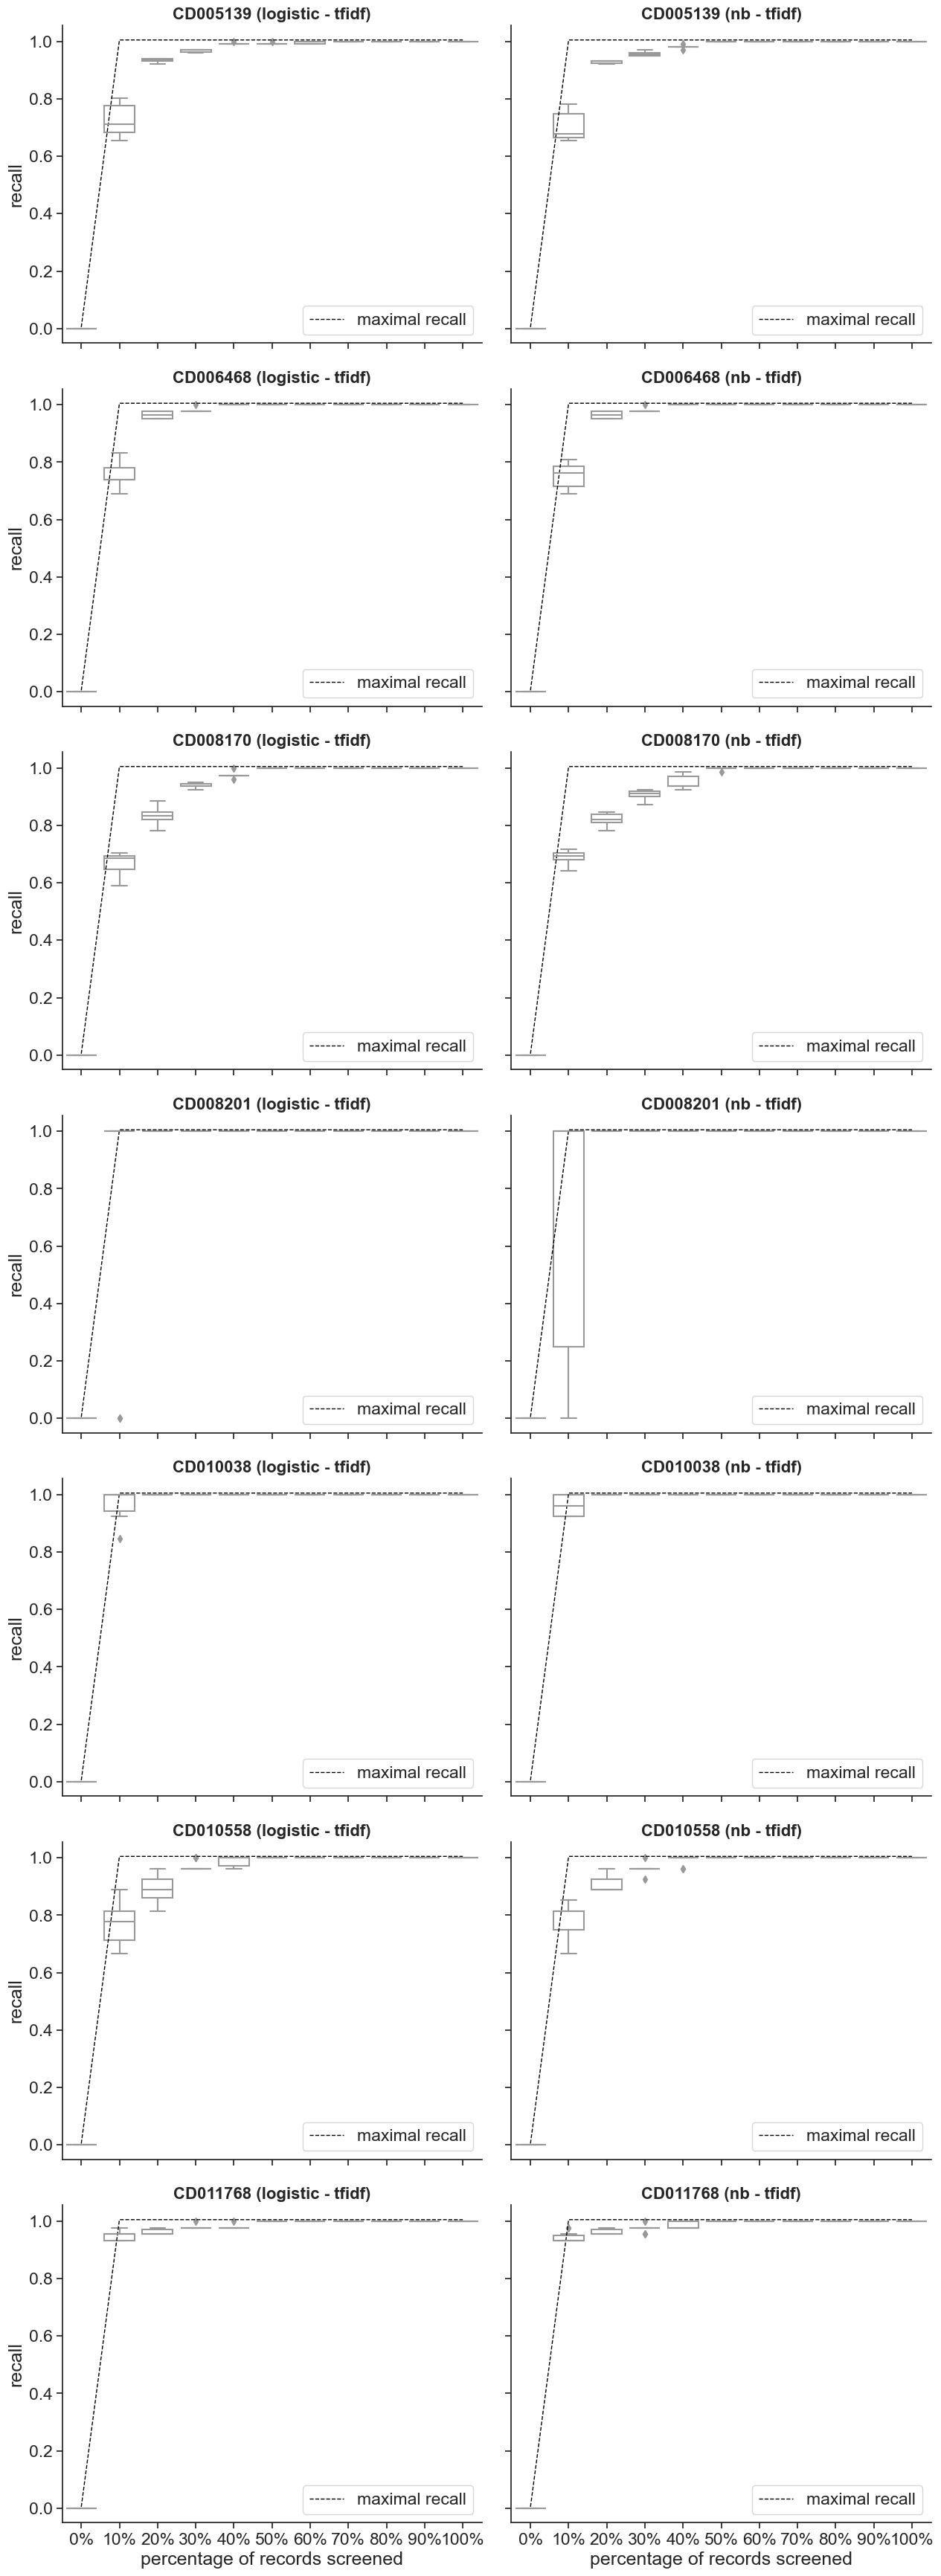

In [26]:
# %%capture
generate_boxplots(df_prop, df_max_recalls)

Create lineplots for all simulations (or any other subset of data/modeling methods):

In [27]:
def generate_lineplots(df_prop, df_max_recalls, subset_reviews = None):
    
    # Select the subset from the dataframe containing all recall values for each proportion screened
    df_lineplots = df_prop.copy()
    
    model_order_full = [
        'tfidf - nb',
        'tfidf - svm',
        'tfidf - logistic',
        'sbert - svm',
        'sbert - logistic'
    ]
    
    # Determine which models are actually present
    present_models = [model for model in model_order_full if model in df_lineplots['Models'].unique()]
    
    # Set the order conditionally
    df_lineplots['Models'] = df_lineplots['Models'].astype(pd.CategoricalDtype(categories=present_models, ordered=True))
    
    if subset_reviews != None:
        reviews = '|'.join(subset_reviews)
        df_lineplots = df_lineplots[df_lineplots['Review'].str.contains(reviews, regex=True)]

    # Create a figure with lineplots for each review-model combination seperately
    p2 = sns.catplot(data = df_lineplots, kind = 'point', 
                     x = 'percentage of records screened', y = 'recall', 
                     col = 'Review_full', 
                     hue = 'Models', 
                     errorbar = 'ci',
                     col_wrap = 2, aspect = 1.4, legend = False
                     )

    axes = p2.fig.axes

    for i in range(0, len(df_lineplots['Review'].unique())):
        max_recalls_per_prop = df_max_recalls.loc[df_max_recalls['Review'] == df_lineplots['Review'].unique()[i]]['Maximum recall']    
        manual_screening = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        x_axis = df_lineplots['percentage of records screened'][0:len(max_recalls_per_prop)]
        axes[i].plot(x_axis, max_recalls_per_prop + 0.005, 'k-', linewidth = 1, color = 'grey', linestyle = '--', label = "maximum recall") 
        axes[i].plot(x_axis, manual_screening, 'k-', linewidth = 1, color = 'grey', linestyle = '-', label = "manual screening") 
        axes[i].legend(loc="lower right", fontsize = 12.5)

    if subset_reviews[0] == 'Int7':
        p2.set_titles('Intervention A1', size = 16, weight = 'bold')
    else:
        p2.set_titles(col_template = "{col_name}", size = 16, weight = 'bold')
    p2.set_xlabels('Percentage of records screened', size = 16)
    p2.set_ylabels('Recall', size = 16)
    p2.set(ylim = (0, 1.01))
    plt.show()

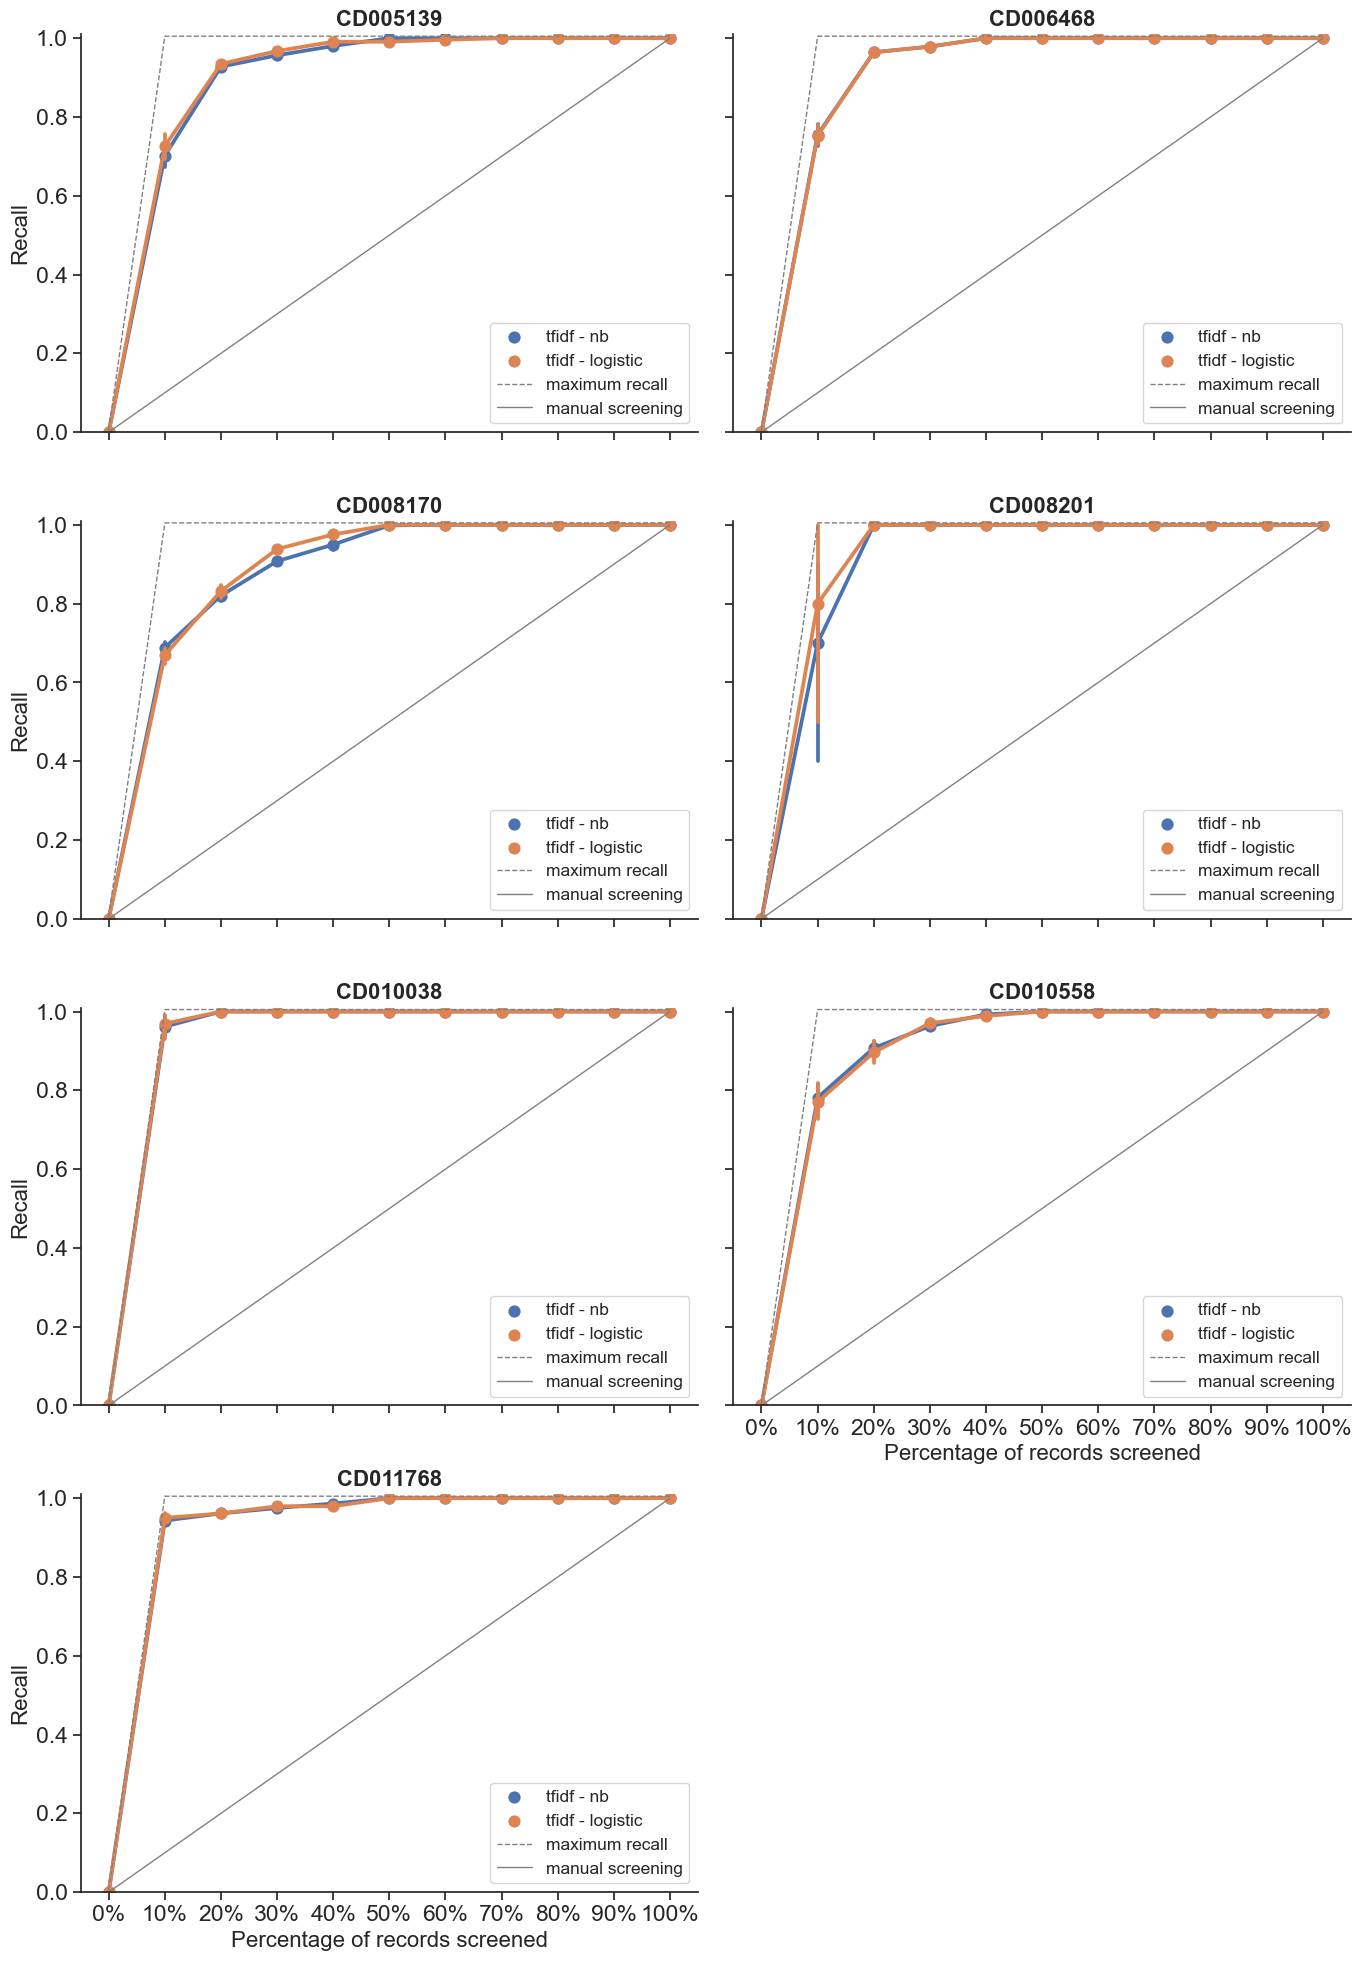

In [28]:
# %%capture
subset_reviews = ['C']
generate_lineplots(df_prop, df_max_recalls, subset_reviews)

##### **End of notebook**